# Linear Models for Regression

## Bias-Variance decomposition

the total loss is given by 

$$
    bias^2 + variance + noise
$$

Where the bias is given by the difference of the expected value of the model for a dataset compared to the expecte value of all the models

$$
    bias = (E_D[y, D] - h(x))^2
$$

So a low bias would mean that most models are around the overall mean and that per data set there aren't much changes. while a high bias would mean that all the predictions are off. This would imply that you have chosen the wrong model or a model that is not complex enough. Variance is given by

$$
    variance = E_D[y(x,d) - E_D[y(x,d)]^2]
$$

So the variance gives an indication on how much the predictions change for a dataset. Low variance means that irrespective of the data the model keeps making consistent predictions. High variance means that the predictions are heavily dependent on the dataset presented

In [1]:
def create_gaussian(i):
    def _(x):
        return np.exp(-(x - i)**2 / 0.1)
    
    return _

In [2]:
import numpy as np
import matplotlib.pyplot as plt

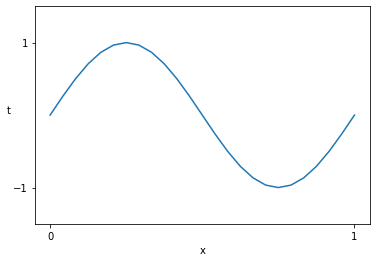

In [3]:
input_data = np.linspace(0, 1, 25)

true_func = lambda x : np.sin(2 * np.pi * x)

plt.plot(input_data, true_func(input_data))
plt.xticks(np.linspace(0,1,2))
plt.xlabel('x')
plt.yticks(np.linspace(-1, 1, 2))
plt.ylim(-1.5, 1.5)
plt.ylabel('t', rotation=0)
plt.show()

In [97]:
basis_functions = []

bias_func = lambda x : x
basis_functions.append(bias_func)


for index, i in enumerate(range(24)):
    basis_functions.append(create_gaussian(np.random.uniform(0, 1)))

The optimal value for $w$ is given by

$$
    w = (\lambda I + \phi^T\phi)^{-1}\phi^T t
$$

In [116]:
# Create 100 fake datasets and corresponding labels
datasets = []
labels = []

for i in range(100):
    data = np.random.uniform(0, 1, 25)
    datasets.append(data)
    labels.append(true_func(data).reshape(-1, 1) + np.random.normal(0, 0.60, (25, 1)))

In [117]:
def transform_input(X):
    phi = [] # M x N (25 x 25)
    
    for x in X: # For each example in 
        data = []
        for function in basis_functions:
            data.append(function(x))
            
        phi.append(data)
            
    return np.vstack(phi)
        

<BarContainer object of 25 artists>

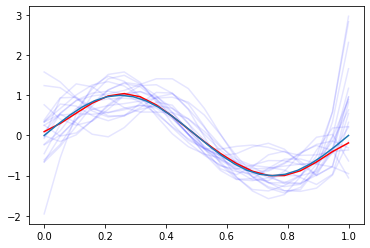

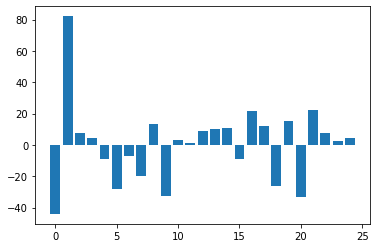

In [129]:
# For each dataset, transform usign the basisfunctions and find the optimal w
L = 0.00001 
test_input = np.linspace(0, 1, 20)

predictions = []

for index, dataset in enumerate(datasets):
    phi = transform_input(dataset) # N x M 
    w_star = np.linalg.inv((L * np.identity(len(basis_functions))) + (phi.T  @ phi)) @ phi.T @ labels[index]
    
    transformed = transform_input(test_input)
    predictions.append((w_star.T @ transformed.T)[0])

for i in range(20):
    plt.plot(test_input, predictions[i], c='b', alpha=0.10)
    
plt.plot(test_input, np.vstack(predictions).mean(axis=0), c='r')
plt.plot(input_data, true_func(input_data))

plt.figure()
plt.bar(np.arange(w_star.shape[0]), w_star.flatten())

<BarContainer object of 25 artists>

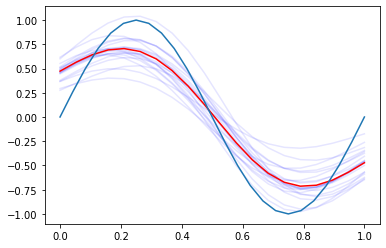

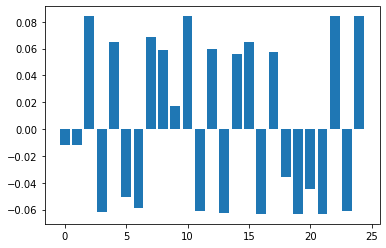

In [127]:
# For each dataset, transform usign the basisfunctions and find the optimal w
L = np.exp(2.6) 
test_input = np.linspace(0, 1, 20)

predictions = []

for index, dataset in enumerate(datasets):
    phi = transform_input(dataset) # N x M 
    w_star = np.linalg.inv((L * np.identity(len(basis_functions))) + (phi.T  @ phi)) @ phi.T @ labels[index]
    
    transformed = transform_input(test_input)
    predictions.append((w_star.T @ transformed.T)[0])

for i in range(20):
    plt.plot(test_input, predictions[i], c='b', alpha=0.10)
    
plt.plot(test_input, np.vstack(predictions).mean(axis=0), c='r')
plt.plot(input_data, true_func(input_data))

plt.figure()
plt.bar(np.arange(w_star.shape[0]), w_star.flatten())

<BarContainer object of 25 artists>

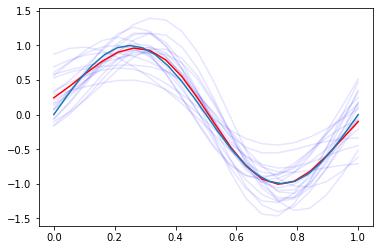

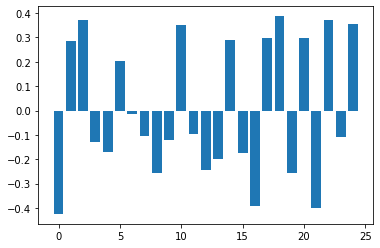

In [125]:
# For each dataset, transform usign the basisfunctions and find the optimal w
L = np.exp(-2.4) 
test_input = np.linspace(0, 1, 20)

predictions = []

for index, dataset in enumerate(datasets):
    phi = transform_input(dataset) # N x M 
    w_star = np.linalg.inv((L * np.identity(len(basis_functions))) + (phi.T  @ phi)) @ phi.T @ labels[index]
    
    transformed = transform_input(test_input)
    predictions.append((w_star.T @ transformed.T)[0])

for i in range(20):
    plt.plot(test_input, predictions[i], c='b', alpha=0.10)
    
plt.plot(test_input, np.vstack(predictions).mean(axis=0), c='r')
plt.plot(input_data, true_func(input_data))

plt.figure()
plt.bar(np.arange(w_star.shape[0]), w_star.flatten())

What this shows is the picking a good regularization parameter is quite important for model peformance. Optimizing is quite difficult. Using a bayesian approach we can overcome the problems since we learn the optimal w using only a prior distribution over w. 


## Bayesian Linear Regression

One of the main issues with the maximum likelihood method is that it will always pick the most complex model to be the best performing model. This can be overcome by using a bayesian method where you add a prior to the conditional probability of $w$

In [1]:
# from https://docs.pymc.io/notebooks/updating_priors.html
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param, x, y)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

In [3]:
# True parameter values
alpha_true = -0.30
beta0_true = 0.5

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 +  np.random.normal(0, 0.2, size)

In [4]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    intercept = Normal('intercept', mu=0, sigma=0.20)
    w1 = Normal('w1', mu=0, sigma=0.20)
    
    # Expected value of outcome
    mu = intercept + w1 * X1 
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sigma=1, observed=Y)
    
    # draw 1000 posterior samples
    trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8838553709573617, but should be close to 0.8. Try to increase the number of tuning steps.


In [5]:
traces = [trace]

for i in range(12):

    # generate more data
    X1 = np.random.randn(size)
    Y = alpha_true + beta0_true * X1 +  np.random.normal(0, 0.2, size)
    
    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        intercept = from_posterior('intercept', trace['intercept'])
        w1 = from_posterior('w1', trace['w1'])

        # Expected value of outcome
        mu = intercept + w1 * X1

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sigma=1, observed=Y)

        trace = sample(1000, cores=1)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8821497756296255, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Posterior distributions after 13 iterations.


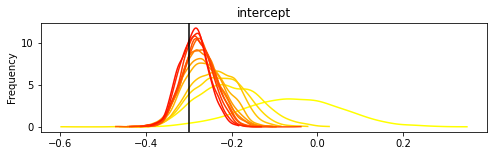

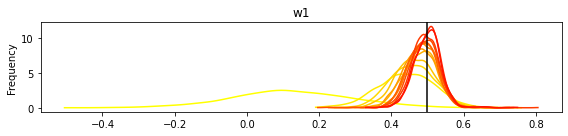

In [6]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['intercept', 'w1']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'intercept': alpha_true, 'w1': beta0_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)

plt.tight_layout()

In [7]:
from scipy.stats import multivariate_normal

In [8]:
def plot_posterior(trace, axis):
    prior = np.concatenate([trace.intercept.reshape(1, -1), trace.w1.reshape(1, -1)], axis=0)

    covariance = np.cov(prior) 
    means = np.array([trace.intercept.mean(), trace.w1.mean()])

    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = multivariate_normal(means, covariance)

    axis.contour(rv.pdf(pos).T, cmap='jet')
    axis.set_xticks(np.linspace(0, 200, 3))
    axis.set_xlabel(r'$intercept$')
    axis.set_ylabel(r'$w_1$')
    axis.set_yticks(np.linspace(0, 200, 3))
    

    return axis

In [9]:
def plot_equations(trace, axis):
    x = np.linspace(0, 1, 2)
    for sample in np.random.choice(trace, 5):
        axis.plot(sample['intercept'] + sample['w1'] * x, c='r', alpha=0.30)

    axis.plot(sample['intercept'].mean() + sample['w1'].mean() * x, label='mean')
    axis.plot(alpha_true + beta0_true * x, c='g', label='true')
    axis.legend()

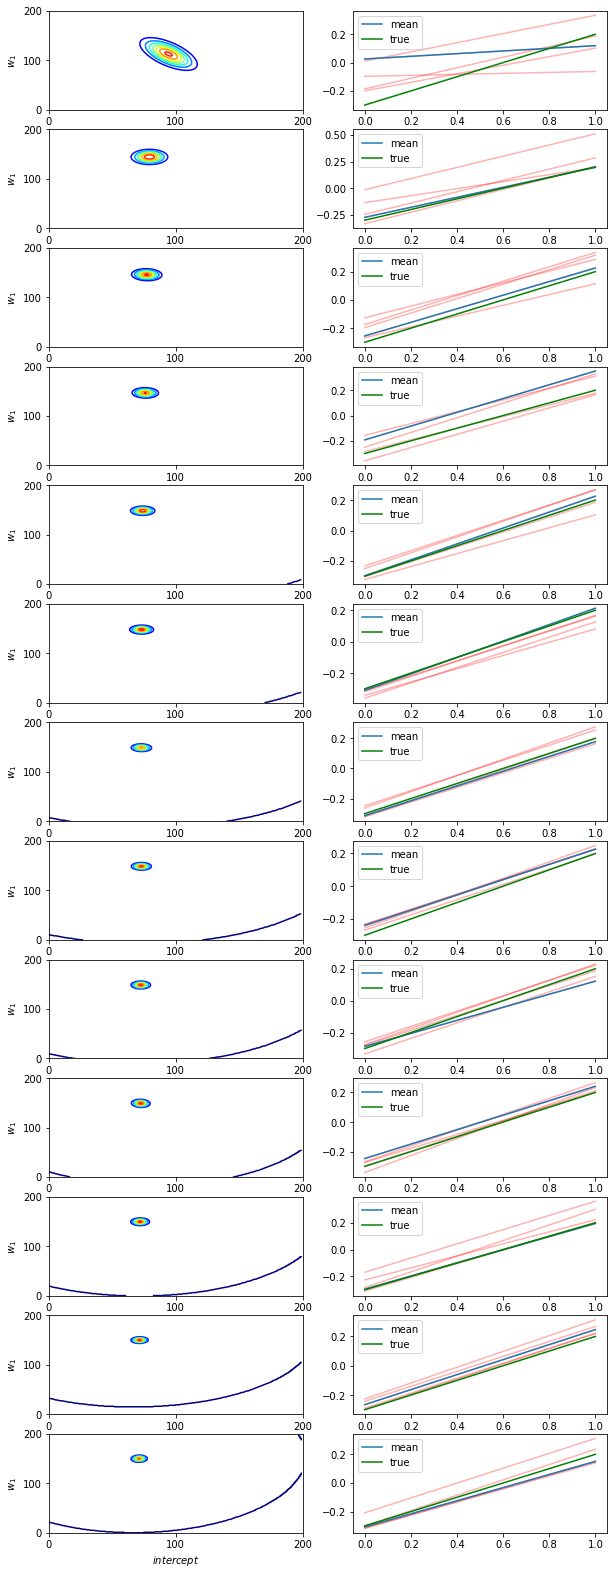

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=len(traces), figsize=(10, 28))

for index, trace in enumerate(traces):
    plot_posterior(trace, axes[index, 0])
    plot_equations(trace, axes[index, 1])
